<a href="https://colab.research.google.com/github/edygordo/Algorithms/blob/master/Polyastro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install poliastro

     |████████████████████████████████| 132 kB 7.4 MB/s 
     |████████████████████████████████| 4.4 MB 44.5 MB/s 
     |████████████████████████████████| 40 kB 5.7 MB/s 
     |████████████████████████████████| 802 kB 33.5 MB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 
     |████████████████████████████████| 3.5 MB 27.4 MB/s 
  Created wheel for jplephem: filename=jplephem-2.16-py3-none-any.whl size=46793 sha256=9f32fd1b5c2ab65b8c660e81ee26ca3a54e4a0cb2cf14556da2d9aa50ccae286
  Stored in directory: /root/.cache/pip/wheels/c5/d6/01/722338266e80ec9e7a2faaf4e13fce9e6721fb0e2cd5308c7d
  Created wheel for mimeparse: filename=mimeparse-0.1.3-py3-none-any.whl size=3864 sha256=680e307581b14ebc2bec42de60a3f6ce83986588bb0fbca33f5f62bda502f123
  Stored in directory: /root/.cache/pip/wheels/49/b4/2d/0081759ae1833bd694024801f7aacddcda8a687e8d5fbaeebd
Successfully built jplephem mimeparse


In [2]:
from google.colab import files
from matplotlib import pyplot as plt
import numpy as np
from numpy.linalg import norm

from astropy.coordinates import solar_system_ephemeris
from astropy.time import Time, TimeDelta
from astropy import units as u

from poliastro.bodies import Earth, Moon, Sun
from poliastro.constants import rho0_earth, H0_earth

from poliastro.core.elements import rv2coe
from poliastro.core.perturbations import atmospheric_drag_exponential, third_body, J2_perturbation, J3_perturbation, radiation_pressure, atmospheric_drag_model
from poliastro.core.propagation import func_twobody
from poliastro.earth.atmosphere import COESA76

from poliastro.ephem import build_ephem_interpolant
from poliastro.plotting import OrbitPlotter3D
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import propagate, cowell

# More info: https://plotly.com/python/renderers/
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



Attractor, Reference frame, Period:-Earth (♁), <bound method Orbit.get_frame of 6650 x 46550 km x 63.4 deg (GCRS) orbit around Earth (♁) at epoch J2000.000 (TT)>, 0.49971190141372096 s


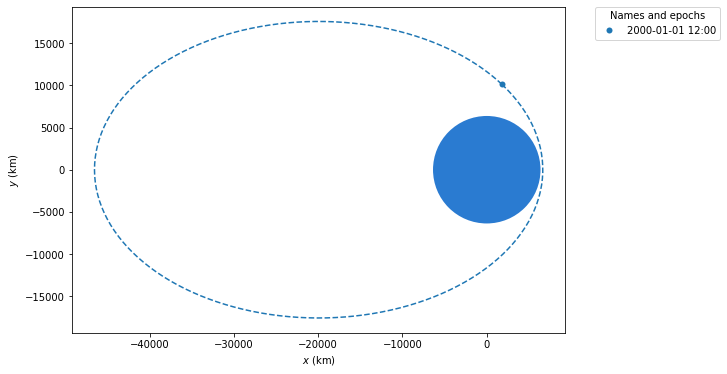

In [3]:
from poliastro.examples import molniya
molniya.plot()
type(molniya)
print(f'Attractor, Reference frame, Period:-{molniya.attractor}, {molniya.get_frame}, {molniya.period/(24*60*60)}')

In [4]:
from astropy import units as u
from poliastro.bodies import Mars,Earth,Sun
from poliastro.twobody import Orbit # this Orbit object stores all the relevenant information to completely define orbit(6 OEV) with time at which the orbit was defined

# Given the position r and velocity v of a satellite in the geocentric equatorial frame(ECI-J2000), how do we obtain the orbital elements?
# Data from Curtis, example 4.3
r = [-6045, -3490, 2500] * u.km
v = [-3.457, 6.618, 2.533] * u.km / u.s

orb = Orbit.from_vectors(Earth, r, v) # We define the state vector [r,v] of a satellite in geocentric equatorial frame, and Earth for (gravitational constant parameter)

type(orb)


poliastro.twobody.orbit.Orbit

<GCRS Frame (obstime=J2000.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s)>

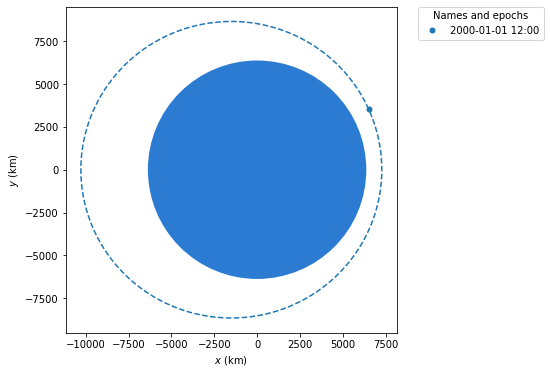

In [5]:
orb.plot() # Plotting done in per-focal reference frame
           # The dotted line represents osculatting orbit, an ideal Keplerian Orbit at that instant of satellite
orb.epoch
orb.epoch.iso
# to get the frame in which orbit is described in use
# Geo-Centric Reference frame
orb.get_frame()

In [6]:
# Data for Mars at J2000 from JPL HORIZONS
a = 1.523679 * u.AU
ecc = 0.093315 * u.one
inc = 1.85 * u.deg
raan = 49.562 * u.deg
argp = 286.537 * u.deg
nu = 23.33 * u.deg

# The frame of object orb is in HCRS(Helio Centric Reference System)
orb = Orbit.from_classical(Sun, a, ecc, inc, raan, argp, nu)
print(orb.get_frame())
orb.period

<HCRS Frame (obstime=J2000.000)>


<Quantity 59354327.53239401 s>

In [7]:
# Finding a satellite parameters , nu(True Anamoly), n(Mean Motion) . Converting them to desired unit
from poliastro.examples import iss
iss.nu.to(unit=u.deg)
iss.n.to(unit=u.deg/u.min)
print(f'True Anomaly(in degree) of ISS Orbit is in:-{iss.nu.to(unit=u.deg)}')
print(f'Epoch time of ISS:-{iss.epoch}')
print(type(iss))

True Anomaly(in degree) of ISS Orbit is in:-46.5958046770576 deg
Epoch time of ISS:-2013-03-18 12:00:00.000
<class 'poliastro.twobody.orbit.Orbit'>


In [8]:
# How to propagate a satellite in a given reference frame?
# use propagate method present in astropy
# Propagating ISS(International Space Station) for 30 minute in GCRS

iss_30m = iss.propagate(30 * u.min)
iss_30m.epoch
print(iss_30m.nu.to(unit=u.deg))
print(f'Time now:-{iss_30m.epoch.iso}')

163.14093620348706 deg
Time now:-2013-03-18 12:30:00.000


# Perturbation Model

In [ ]:
# rv2coe(Earth.k.to_value(u.km ** 3 / u.s ** 2),position_vector_cartesian[0],velocity_vector_cartesian[0])

Initial eccentricity is:-0.1713603407640222
Satellite frame is:-<GCRS Frame (obstime=J2000.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s)>


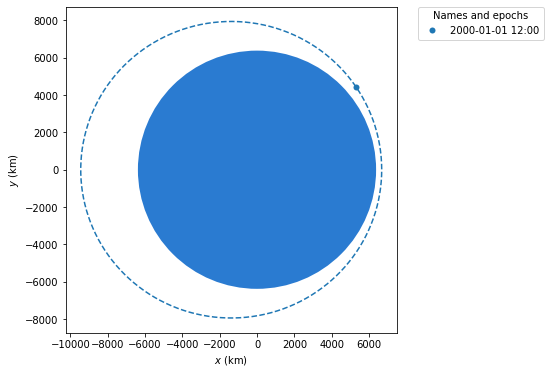

In [9]:
r0 = [-2384.46, 5729.01, 3050.46] * u.km
v0 = [-7.36138, -2.98997, 1.64354] * u.km / u.s
my_satellite = Orbit.from_vectors(Earth, r0, v0)
print(f'Initial eccentricity is:-{my_satellite.ecc}')
my_satellite.plot()
print(f'Satellite frame is:-{my_satellite.get_frame()}')
# my_satellite = Orbit.circular(Earth, 250 * u.km)
# plt.savefig('Initial Position of Satellite.jpg')
# files.download('Initial Position of Satellite.jpg')

In [10]:
epoch = Time('2021-06-7 12:00:00', format='iso', scale='utc')
epoch = Time(epoch.jd, format="jd", scale="tdb")
body_s = build_ephem_interpolant(Sun, 28 * u.day, (epoch.value * u.day, epoch.value * u.day + 5 * u.day), rtol=1e-5) # (initial and final epoch)

In [11]:
# Creating a moon Ephemeris interpolater function
# Building Moon Ephemeris Data prior to adding third body perturbation
solar_system_ephemeris.set("de432s") # database keeping positions of bodies in Solar system over time
epoch = Time(my_satellite.epoch.jd, format="jd", scale="tdb") # setting the exact event date is important, format = julian Date,  Barycentric Dynamical Time (TDB)
                                                      # The time scale (or time standard) is “a specification for measuring time: either the rate at which time passes; or points in time; or both
                                                      # Julian Date time format. This represents the number of days since the beginning of the Julian Period. For example, 2451544.5 in JD is midnight on January 1, 2000.
# body_r returns a CartesianRepresentation of the barycentric position of a body(Moon in our case) (i.e., in the ICRS frame)
body_r = build_ephem_interpolant(Moon, 28 * u.day, (epoch.value * u.day, epoch.value * u.day + 5 * u.day), rtol=1e-5) # (initial and final epoch)
# 1:42 execution time

In [12]:
# Creating a moon Ephemeris interpolater function
# Building Moon Ephemeris Data prior to adding third body perturbation
solar_system_ephemeris.set("de432s") # database keeping positions of bodies in Solar system over time
epoch = Time(my_satellite.epoch.jd, format="jd", scale="tdb") # setting the exact event date is important, format = julian Date,  Barycentric Dynamical Time (TDB)
                                                      # The time scale (or time standard) is “a specification for measuring time: either the rate at which time passes; or points in time; or both
                                                      # Julian Date time format. This represents the number of days since the beginning of the Julian Period. For example, 2451544.5 in JD is midnight on January 1, 2000.
# body_r returns a CartesianRepresentation of the barycentric position of a body(Moon in our case) (i.e., in the ICRS frame)
body_s = build_ephem_interpolant(Sun, 28 * u.day, (epoch.value * u.day, epoch.value * u.day + 5 * u.day), rtol=1e-5) # (initial and final epoch)

/usr/local/lib/python3.7/dist-packages/poliastro/ephem.py:60: RuntimeWarning:

divide by zero encountered in double_scalars



OverflowError: ignored

In [ ]:
# from astropy.coordinates import solar_system_ephemeris, EarthLocation
# from astropy.coordinates import get_body_barycentric, get_body, get_moon
# # For radiation pressure get the location of sun in GCRS frame(The attractor frame)
# t = Time(my_satellite.epoch.jd, format="jd", scale="tdb")
# loc = EarthLocation.of_site('greenwich')
# sun = get_body('sun', t, loc) 
# sun.obsgeoloc # The position of the observer relative to the center-of-mass of the Earth, oriented the same as BCRS/ICRS.
# sun.obsgeovel # The velocity of the observer relative to the center-of-mass of the Earth, oriented the same as BCRS/ICRS.
# sun.representation_type = 'cartesian'
# distance_from_sun = norm([sun.x.value,sun.y.value,sun.z.value]) # position of Sun in GCRS frame
# distance_from_sun = distance_from_sun * u.km
# distance_from_sun

In [ ]:
# loc_of_observer = EarthLocation.of_site('greenwich')
# time_array = TimeDelta(np.linspace(0 * u.d, 5 * u.d, num=31184))
# def generate_sun_ephemeris(time_array):
#   time_array = my_satellite.epoch.jd + time_array
#   sun_ephem = [get_body('sun', Time(t.value,format="jd", scale="tdb") , loc) for t in time_array]
#   return sun_ephem
# sun_ephem = generate_sun_ephemeris(time_array)
# sun_ephem

In [13]:
body_r(1) # with 28 days orbital period

array([-291623.08832022, -266701.71859627,  -76099.28525442])

In [ ]:
body_r(1) # with 400 days orbital period

array([-291623.08832022, -266701.71859627,  -76099.28525442])

In [23]:
# Pertubations

from numba import njit
# njit is just for faster computation using numba library
# k is Orbit's Gravitational constant(mu=G*(M_attractor))
# state is numpy array[position,velocity]
# accel is providing constant acceleration(A Demo Perturbation) along the tangent. Will be useful to know how to add Other perterbations.
# norm_v is directional unit vector
# func_twobody is using a cowell model to propagte satellite in orbit, it returns d(state_vec)/dt = [velocity_3,acceleration_3]
# Note state_vec here in [km, km/s]
# func_twobody solves differential equation which is an initial value problem
# t0 = time after epoch time, u_ = state_vector[pos,vel], k = gravitational constant

@njit
def accel_thrust( state):
    """Constant acceleration aligned with the velocity. """
    v_vec = state[3:]
    norm_v = (v_vec * v_vec).sum() ** 0.5
    return 1e-5 * v_vec / norm_v


def accel_atm_drag(t0, state, k, R,C_D,A_over_m,H0,rho0):
  """acceleration due to atmoshperic drag(more prominent in Near Earth orbit satellites). """
  return atmospheric_drag_exponential(t0,state,k,R=R,C_D=C_D,A_over_m=A_over_m, H0=H0,rho0=rho0)
 
 

simulation_time = []
def f(t0, u_, k):
    simulation_time.append(t0)

    # Keplerian Acceleration( Ideal Motion)
    du_kep = func_twobody(t0, u_, k)
    
    # Constant thrust Acceleration
    ax, ay, az = accel_thrust(u_)
    du_thrust = [0,0,0,ax,ay,az]

    # Atmoshperic Drag Acceleration

    # Atmosphere parameters
    # H0 : float         Atmospheric scale height, (km)
    # rho0: float       Exponent density pre-factor, (kg / km^3)

    R = Earth.R.to(u.km).value # Radius of attractor(Earth)
    k # G*Me
    C_D = 2.2 # Dimensionless quantity, related to satellite shape
    A_over_m = ((np.pi / 4.0) * (u.m ** 2) / (100 * u.kg)).to_value(u.km**2/u.kg) # effective spacecraft area/mass of the spacecraft (km^2/kg)
    B = C_D * A_over_m
    rho0 = rho0_earth.to(u.kg / u.km ** 3).value
    H0 = H0_earth.to(u.km).value
    ax, ay, az = accel_atm_drag(t0, u_, k, R, C_D, A_over_m,H0, rho0)
    du_atm = np.array([0, 0, 0, ax, ay, az])
    
   # Another model for atmospheric drag
  
     # Atmoshperic Drag Acceleration
    A_over_m = ((np.pi / 4.0) * (u.m ** 2) / (100 * u.kg)).to_value(u.km**2/u.kg) # effective spacecraft area/mass of the spacecraft (km^2/kg)
    ax, ay, az = atmospheric_drag_exponential(t0,u_,k,R=Earth.R.to(u.km).value,C_D=2.2,A_over_m=A_over_m,H0=H0,rho0=rho0)
    du_atm2 = [0,0,0,ax,ay,az]

    # Radiation Pressure
    C_R = 1.5
    Wdivc_s = 3.9 # total star emitted power divided by the speed of light (W * s / km)
    ax, ay, az = 10*radiation_pressure(t0,u_,k,R,C_R,A_over_m,Wdivc_s,body_s)
    du_rad = [0,0,0,ax,ay,az]


    # J2 Perturbation , Because of Oblateness of Earth(Flatter at poles and bulges at equator)
    # Because of this RAAN, Argument of perigee and time since perigee are affected
    ax, ay, az = J2_perturbation(t0, u_, k, J2=Earth.J2.value,R=Earth.R.to(u.km).value)
    du_J2 = [0,0,0,ax,ay,az]

    # J3 pertubation haven't been validated yet,
    ax, ay, az = J3_perturbation(t0, u_, k, J3=Earth.J3.value,R=Earth.R.to(u.km).value)
    du_J3 = [0,0,0,ax,ay,az]

    # Perturbation due to Moon, 3rd Body perturbation, need to create a 3rd body from solar_system_ephemeris
    ax, ay, az = third_body(t0, u_, k, k_third=400 * Moon.k.to(u.km ** 3 / u.s ** 2).value, perturbation_body=body_r) # state = u_
    du_third = [0,0,0,ax,ay,az]

    return du_kep + du_atm2 + du_rad + du_J2 + du_J3 + du_third

# Propagated_satellite = my_satellite.propagate(5 * u.day,method=cowell,f=f, tofs=tofs)
# Propagated_epoch_time = Propagated_satellite.epoch
# Propagated_anomaly_degree = Propagated_satellite.nu.to(unit=u.deg)
# Propagated_eccentricity = Propagated_satellite.ecc

In [ ]:
from poliastro.earth.atmosphere import COESA76
COESA76().density(alt=1000*u.km)

<Quantity 3.55945127e-15 kg / m3>

In [24]:
tofs = TimeDelta(np.linspace(0 * u.d, 5 * u.d, num=31184))
my_satellite_propagated = propagate(
    my_satellite,
    tofs,
    method=cowell,
    f=f,
)

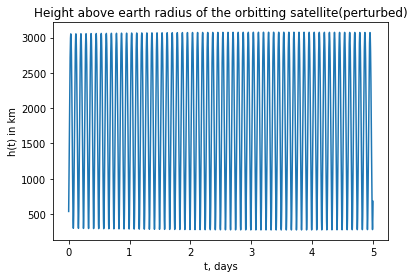

In [25]:
# Height Check during propagation of satellite
plt.title('Height above earth radius of the orbitting satellite(perturbed)')
plt.ylabel("h(t) in km")
plt.xlabel("t, days")
tofs = TimeDelta(np.linspace(0 * u.h, 5 * u.d, num=31184))

height = (my_satellite_propagated.norm().value - Earth.R.to_value(unit=u.km))

plt.plot(tofs.value, height)
#plt.savefig('Height Of Satellite Perturbed.jpg')
#files.download('Height Of Satellite Perturbed.jpg')

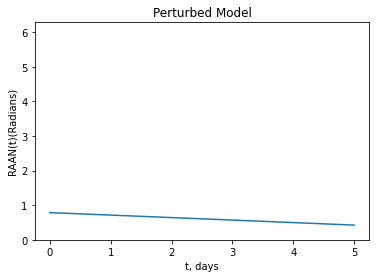

In [26]:
position_vector_cartesian = my_satellite_propagated.xyz.T.to(u.km).value
velocity_vector_cartesian = my_satellite_propagated.differentials["s"].d_xyz.T.to(u.km / u.s).value
# Checking effect on RAAN
raans = [rv2coe(Earth.k.to_value(u.km ** 3 / u.s ** 2), r, v)[3] for r, v in zip(position_vector_cartesian, velocity_vector_cartesian)]
plt.title('Perturbed Model')
plt.ylim([0, 2*np.pi])
plt.ylabel("RAAN(t)(Radians)")
plt.xlabel("t, days")
plt.plot(tofs.value, raans)
#plt.savefig('Raan Perturbed.jpg')
#files.download('Raan Perturbed.jpg')

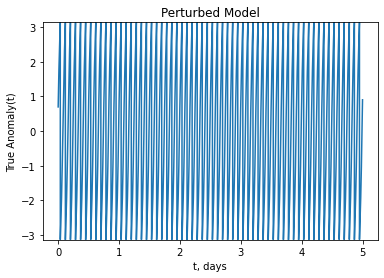

In [27]:
# Find true anamoly
true_anomaly = [rv2coe(Earth.k.to_value(u.km ** 3 / u.s ** 2), r, v)[5] for r, v in zip(position_vector_cartesian, velocity_vector_cartesian)]
plt.ylim([-np.pi, np.pi])
plt.title('Perturbed Model')
plt.ylabel("True Anomaly(t)")
plt.xlabel("t, days")
plt.plot(tofs.value, true_anomaly)
#plt.savefig('True Anamoly perturbed.jpg')
#files.download('True Anamoly perturbed.jpg')

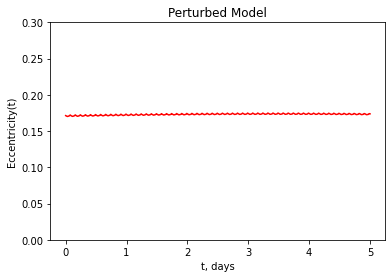

In [28]:
# Find eccentricity
eccen = [rv2coe(Earth.k.to_value(u.km ** 3 / u.s ** 2), r, v)[1] for r, v in zip(position_vector_cartesian, velocity_vector_cartesian)]
plt.title('Perturbed Model')
plt.ylim([0,0.3])
plt.ylabel("Eccentricity(t)")
plt.xlabel("t, days")
plt.plot(tofs.value, eccen, 'r')
#plt.savefig('Eccentricity perturbed.jpg')
#files.download('Eccentricity perturbed.jpg')

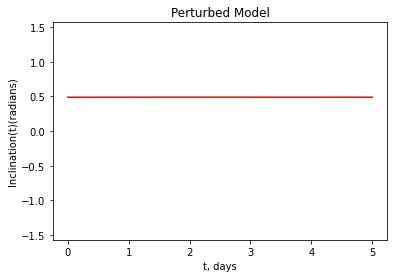

In [29]:
# Find inclination
inclination = [rv2coe(Earth.k.to_value(u.km ** 3 / u.s ** 2), r, v)[2] for r, v in zip(position_vector_cartesian, velocity_vector_cartesian)]
plt.title('Perturbed Model')
plt.ylim([-np.pi/2,np.pi/2])
plt.ylabel("Inclination(t)(radians)")
plt.xlabel("t, days")
plt.plot(tofs.value, inclination, 'r')
#plt.savefig('inclination perturbed.jpg')
#files.download('inclination perturbed.jpg')

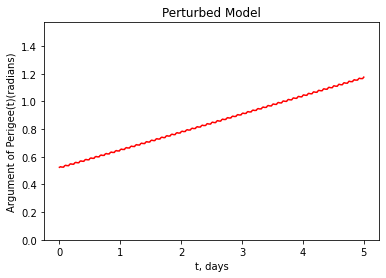

In [30]:
# Find argument of perigee
argu_perigee = [rv2coe(Earth.k.to_value(u.km ** 3 / u.s ** 2), r, v)[4] for r, v in zip(position_vector_cartesian, velocity_vector_cartesian)]
plt.title('Perturbed Model')
plt.ylim([0,np.pi/2])
plt.ylabel("Argument of Perigee(t)(radians)")
plt.xlabel("t, days")
plt.plot(tofs.value, argu_perigee, 'r')
#plt.savefig('Argument of Perigee Perturbed.jpg')
#files.download('Argument of Perigee Perturbed.jpg')

In [ ]:
# # Checking effect of third body perturbation

# frame = OrbitPlotter3D()

# frame.set_attractor(Earth)
# frame.plot_trajectory(my_satellite_propagated, label="orbit influenced by Selected Perturbations")

In [ ]:
# Plotting of Initial state of Satellite

from poliastro.plotting import OrbitPlotter3D

print('Initial State of satellite')
print(f'Epoch time is:- {my_satellite.epoch.iso}')
print(f'Eccentricity is:-{my_satellite.ecc}')
print(f'Semi-Major axis is:-{my_satellite.a}')
print(f'Raan angle is:-{my_satellite.raan}')
print(f'Argument of perigee is:-{my_satellite.argp}')
print(f'Inclination angle is:-{my_satellite.inc}')

Initial State of satellite
Epoch time is:- 2000-01-01 12:00:00.000
Eccentricity is:-0.1713603407640222
Semi-Major axis is:-8058.987609736672 km
Raan angle is:-0.7853981940178838 rad
Argument of perigee is:-0.5235940755330362 rad
Inclination angle is:-0.4886915597901586 rad


Text(0, 0.5, 'Simulation Time(sec)')

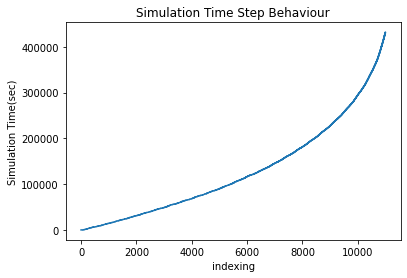

In [ ]:
import matplotlib.pyplot as plt

plt.plot(time_vec)
plt.title('Simulation Time Step Behaviour')
plt.xlabel('indexing')
plt.ylabel('Simulation Time(sec)')

In [ ]:
# Plotting the whole trajectory throughout the simulation time requires to store positions at various time steps

len(time_vec)

31184

In [ ]:
# epoch = Time(2454283.0, format="jd", scale="tdb")
# initial_epoch = epoch.value * u.day
# final_epoch = epoch.value * u.day + 60 * u.day
# print(epoch.iso)
# print((epoch + 60).iso)
# print(initial_epoch)
# print(final_epoch)
# r0 = [-2384.46, 5729.01, 3050.46] * u.km
# v0 = [-7.36138, -2.98997, 1.64354] * u.km / u.s
# initial = Orbit.from_vectors(Earth, r0, v0)
# print(initial.epoch.iso)
# print(initial.epoch.jd)

2000-01-01 12:00:00.000
2451545.0
